# Clasificación de peatones

---

Ithiel Piñero Darias

Visión por computador

11/06/2021 

---



**Aplicar un clasificador SVM. Se deberá implementar HoG (no usar una función ya
implementada).Obtener resultados de bondad del clasificador**

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import random 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Text(0.5, 1.0, 'Persona caminando')

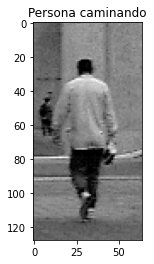

In [ ]:
img = cv2.imread("/content/drive/MyDrive/data_1/pedestrians128x64/per00001.ppm",0)
plt.imshow(img,"gray")
plt.title("Persona caminando")

Text(0.5, 1.0, 'Paisaje sin personas')

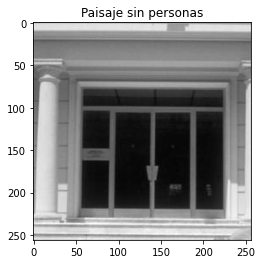

In [ ]:
img = cv2.imread("/content/drive/MyDrive/data_1/pedestrians_neg/a0010.jpg",0)
plt.imshow(img,"gray")
plt.title("Paisaje sin personas") 

Calculamos la orientación y magnitud  de cada imagen, calculando la derivada mediante filtro el filtro propuesto y siguiendo las formulas indicadas en la documentación.

In [ ]:
def Magnitud_and_Orientation_calc(img):
    filtro = np.array([[1,0,-1]])
    Gx=cv2.filter2D(img,-1,filtro).astype(np.float32)
    Gy=cv2.filter2D(img,-1,filtro.T).astype(np.float32)

    m = np.hypot(Gx,Gy)
    m = m.astype("uint8")
    o = np.arctan2(Gy, Gx) + 90
    o = o.astype("uint8")
    return (m,o)

Para la interpolación del histograma hemos creado la función CalcHist

In [ ]:
def calcHist(m,o,inf,sup):
    val1= m * (sup-o)/(sup-inf)
    val2=m * (o-inf)/(sup-inf)
    return (val1,val2)

Calculamos los histogramas, con los 9 bins propuestos. En función del valor de orientación se tendrá en cuenta para cada bin correspondiente el valor de la magnitud. El cálculo se realiza por celdas.

In [ ]:
def histograms(m,o):
    histogram = np.zeros((9))
    bins = [10,30,50,70,90,110,130,150,170,180]
    #Recorrid Bin
    #[0,10) 0
    #[10,30) 1
    #[30,50) 2
    #[50,70) 3
    #[70,90) 4
    #[90,110) 5
    #[110,130) 6 
    #[130,150) 7
    #[150,170) 8
    #[170,180) 0
    for i in range(o.shape[0]):
        for j in range(o.shape[1]):
            #[0,10) and [170,180)
            if((o[i,j] >= 0 and o[i,j] < bins[0]) or (o[i,j] >= bins[8] and o[i,j] < bins[9])):
                if(o[i,j] >= bins[8] and o[i,j] < bins[9]):
                    val1,val2 = calcHist(m[i,j],o[i,j],bins[8],bins[9])
                else:
                    val1,val2 = calcHist(m[i,j],o[i,j],0,bins[0])
                histogram[0] = histogram[0] + val1
                histogram[1] = histogram[1] + val2
            #[10,30)
            elif(o[i,j] >= bins[0] and o[i,j] < bins[1]):
                val1,val2 = calcHist(m[i,j],o[i,j],bins[0],bins[1])
                histogram[1] = histogram[1] + val1
                histogram[2] = histogram[2] + val2
            #[30,50)
            elif(o[i,j] >= bins[1] and o[i,j] < bins[2]):
                val1,val2 = calcHist(m[i,j],o[i,j],bins[1],bins[2])
                histogram[2] = histogram[2] + val1
                histogram[3] = histogram[3] + val2
            #[50,70)    
            elif(o[i,j] >= bins[2] and o[i,j] < bins[3]):
                val1,val2 = calcHist(m[i,j],o[i,j],bins[2],bins[3])
                histogram[3] = histogram[3] + val1
                histogram[4] = histogram[4] + val2
            #[70,90)    
            elif(o[i,j] >= bins[3] and o[i,j] < bins[4]):
                val1,val2 = calcHist(m[i,j],o[i,j],bins[3],bins[4])
                histogram[4] = histogram[4] + val1
                histogram[5] = histogram[5] + val2
            #[90,110)    
            elif(o[i,j] >= bins[4] and o[i,j] < bins[5]):
                val1,val2 = calcHist(m[i,j],o[i,j],bins[4],bins[5])
                histogram[5] = histogram[5] + val1
                histogram[6] = histogram[6] + val2
            #[110,130)    
            elif(o[i,j] >= bins[5] and o[i,j] < bins[6]):
                val1,val2 = calcHist(m[i,j],o[i,j],bins[5],bins[6])
                histogram[6] = histogram[6] + val1
                histogram[7] = histogram[7] + val2
            #[130,150)    
            elif(o[i,j] >= bins[6] and o[i,j] < bins[7]):
                val1,val2 = calcHist(m[i,j],o[i,j],bins[6],bins[7])
                histogram[7] = histogram[7] + val1
                histogram[8] = histogram[8] + val2
            #[150,170)
            elif(o[i,j] >= bins[7] and o[i,j] < bins[8]):
                val1,val2 = calcHist(m[i,j],o[i,j],bins[7],bins[8])
                histogram[8] = histogram[8] + val1
                histogram[0] = histogram[0] + val2
    return histogram

Cálculos de celdas, el tamaño es de 16x8x9 pues es el resultado de dividir el tamaño de la imagen entre celdas de 8x8 con 9 bins cada una.

In [ ]:
def Celdas(img, row_size, col_size):
    celdas = np.zeros((16,8,9))
    r = 0
    c = 0
    for i in range(0,img.shape[0],row_size):
        for j in range(0,img.shape[1], col_size):
            m,o = Magnitud_and_Orientation_calc(img[i:i+row_size, j:j+col_size])
            celdas[r,c,:] = histograms(m,o)
            c = c+1
            if(j == 56):
                r = r+1
                c=0
    return celdas.astype(np.float32)

Generamos los bloques uniendo celdas en bloques de 4x4 con solapamiento de celdas entre bloques.

In [ ]:
def Bloques(celdas):
    bloques = []
    for i in range(celdas.shape[0]):
        for j in range(celdas.shape[1]):
            bloques.append(normalization(np.array(celdas[i:i + 2, j :j + 2].flatten())))
    bloque_norm = np.concatenate([bloque for bloque in bloques])
    return bloque_norm

Realizamos una normalización de los bloques dividiendo el bloque entre la norma más un valor de 0.01 para evitar divisiones entre 0, evitamos que regiones sobresalgan sobre otras en el HOG estableciendo un valor máx de 0.2 y volvemos a realizar la normalización. 

In [ ]:
def normalization(block):
    norm = np.sqrt(np.sum(np.power(block,2)))+0.01
    aux = block / norm
    aux[aux > 0.2] = 0.2
    norm = np.sqrt(np.power(aux,2))+0.01     
    return aux / norm

Carga de imagenes.

In [ ]:
paisajes = "/content/drive/MyDrive/data_1/pedestrians_neg/"
caminando = "/content/drive/MyDrive/data_1/pedestrians128x64/"
images_paisaje = []
images_caminando = []
HOG_X_neg = []
HOG_X_pos = []
y_neg = []
y_pos = []

Función para calcular posiciones aleatoria de paisajes de medidas 128x64 dentro de una imagen 512x51

In [ ]:
def calcPos(image_size, portion_size):
    x1 = random.randint(0, image_size[0]-portion_size[0])
    y1 = random.randint(0, image_size[1]-portion_size[1])

    x2, y2 = x1+portion_size[0], y1+portion_size[1]
    
    return (x1,x2,y1,y2)

En la carga de datos de paisajes aumentamos las muestras tomando varias porciones (5) por imagen de paisaje.

In [ ]:
for filename in os.listdir(paisajes):
    filename = paisajes+filename    
    img = cv2.imread(filename)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (512,512))
    for i in range(5):        
        x1,x2,y1,y2 = calcPos(img.shape, (128,64))
        i = img[x1:x2,y1:y2]
        images_paisaje.append(i)
    
for filename in os.listdir(caminando):
    filename = caminando+filename
    img = cv2.imread(filename)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    images_caminando.append(img)
    

Tomamos 400 imagenes de personas caminando totalmente aleatorias.

In [ ]:
random.shuffle(images_caminando)
random.shuffle(images_paisaje)
images_caminando = images_caminando[:400]

In [ ]:
for i in images_caminando:
    celdas=Celdas(i,8,8)
    bloques = Bloques(celdas)
    HOG_X_pos.append(bloques)
    y_pos.append(1)
    
for i in images_paisaje:    
    celdas=Celdas(i,8,8)
    bloques = Bloques(celdas)
    HOG_X_neg.append(bloques)
    y_neg.append(-1)

In [ ]:
HOG_X_pos = np.array(HOG_X_pos)
y_pos = np.array(y_pos)
HOG_X_neg = np.array(HOG_X_neg)
y_neg = np.array(y_neg)

In [ ]:
print(y_pos.shape)
print(y_neg.shape)
print(HOG_X_neg.shape)
print(HOG_X_pos.shape)

(400,)
(280,)
(280, 4185)
(400, 4185)


In [ ]:
X=np.concatenate([HOG_X_pos,HOG_X_neg])
y=np.concatenate([y_pos,y_neg])
ntrain= round(0.8*len(y))
ntest = len(X)-ntrain
idx = np.random.permutation(np.arange(len(y)))
X_train= X[idx[0:ntrain],:]
y_train=y[idx[0:ntrain]]
X_test= X[idx[ntrain:len(y)],:]
y_test=y[idx[ntrain:len(y)]]

In [ ]:
print("Muestras para train: ",X_train.shape[0])
print("Casos negativos en train: ",y_train[y_train == -1].shape[0])
print("Casos positivos en train: ",y_train[y_train == 1].shape[0])
print("Muestras para test: ",X_test.shape[0])
print("Casos negativos en test: ",y_test[y_test == -1].shape[0])
print("Casos positivos en test: ",y_test[y_test == 1].shape[0])

Muestras para train:  544
Casos negativos en train:  217
Casos positivos en train:  327
Muestras para test:  136
Casos negativos en test:  63
Casos positivos en test:  73


Creación del SVM

In [ ]:
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)

svm.train(X_train.astype(np.float32), cv2.ml.ROW_SAMPLE, y_train)
y_pred_train = svm.predict(X_train.astype(np.float32))[1]
y_pred_test = svm.predict(X_test.astype(np.float32))[1]

Matriz de confusión de Train

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train,y_pred_train) 

array([[217,   0],
       [  0, 327]])

Matriz de confusion de Test, apreciamos un error ligero en la clasifición mayor que en la muestra de train.

In [ ]:
confusion_matrix(y_test,y_pred_test)

array([[61,  2],
       [ 5, 68]])

Hemos obtenido una tasa de acierto del 100% en Train y del 94,85% en Test.

In [ ]:
print("Accuracy en train: ",np.mean(y_train==y_pred_train.T))
print("Accuracy en test: ",np.mean(y_test==y_pred_test.T))

Accuracy en train:  1.0
Accuracy en test:  0.9485294117647058


**Aplicar un clasificador usando una red neuronal de convolución. Se deberán reusar y
modificar las arquitecturas VGG16, ResNet18 y Xception para tal fin. Obtener una
comparativa de bondad usando predictores como agudeza, F1, recall, precision.**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        

1 Physical GPUs, 1 Logical GPUs


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        #Reflejo horizontal
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        #Rotaciones 
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


Carga de imágenes y división en train, test y validación

In [ ]:
import os
import cv2
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

classes = []    
images = []

for filename in os.listdir(paisajes):
  filename = paisajes+filename
  img = cv2.imread(filename)
  img = cv2.resize(img,(512,512))
  for i in range(5):        
        x1,x2,y1,y2 = calcPos((512,512), (150,150))
        i = img[x1:x2,y1:y2]
        images.append(i)
        classes.append(1)

n=0
while n < 400: 
  for filename in os.listdir(caminando):
    filename = caminando+filename
    img = cv2.imread(filename)
    img = cv2.resize(img,(150,150))

    images.append(img)
    classes.append(0)
    n = n+1

classes = np.array(classes)
images = np.array(images)

from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(images, classes, test_size=0.2,
                                                random_state=42)

n_validation = round(0.2*len(ytrain))
X_val = X_train[-n_validation:]
yval = ytrain[-n_validation:]
X_train = X_train[:-n_validation]
ytrain = ytrain[:-n_validation]

In [ ]:
import pandas as pd
df1 = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1_score'], index=["VGG16", "ResNet50", "Xception"])

VGG16

In [ ]:
base_model = keras.applications.VGG16(
    weights="imagenet",  # Cargamos los pesos entrenados con ImageNet.
    input_shape=(150, 150, 3), #por defecto acepta 299x299x3
    include_top=False,#Las primer capa  no se incluye
)

# Congelamos 
base_model.trainable = False

# Añadirmos la primera capa
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Aplicamos el aumento de datos.
#Normalizamos al rango [-1,1]
#usando outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])


x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularizamos
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


model.compile(
    optimizer=keras.optimizers.Adam(),
    #cuando solamente tenemos dos etiquetas. COn from_logits=true para obtener
    #probabilidades
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    #redondea las probabilidades a 0-1 y estima como coincide y_pred y y_real
    metrics=['acc'],
)
#Deberiamos usar más epocas pero por rapidez ponemos 5
epochs = 5
model.fit(X_train, ytrain, epochs=epochs, validation_data=(X_val,yval))

#predecir las etiquetas

base_model.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Una razón de aprendizaje muy pequeña
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc'])

# Entrenamos el modelo entero
model.fit(X_train, ytrain, epochs=5, validation_data=(X_val,yval))

y_prob = model.predict(X_test) 
y_classes = (y_prob > 0.5)*1

#Ahora lo vamos a evaluar
score = model.evaluate(X_test, ytest) 

acc = accuracy_score(ytest, y_classes.reshape(y_classes.shape[0],))
f1 = f1_score(ytest, y_classes.reshape(y_classes.shape[0],), average='weighted')
recall = recall_score(ytest, y_classes.reshape(y_classes.shape[0],), average='weighted')
precision = precision_score(ytest, y_classes.reshape(y_classes.shape[0],), average='weighted')

df1.loc["VGG16"] = [acc, recall, precision, f1]

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/5
25/25 [==============================] - 40s 256ms/step - loss: 0.5604 - acc: 0.7620 - val_loss: 0.4355 - val_acc: 0.7927
Epoch 2/5
25/25 [==============================] - 4s 168ms/step - loss: 0.4501 - acc: 0.7658 - val_loss: 0.3765 - val_acc: 0.7927
Epoch 3/5
25/25 [==============================] - 4s 169ms/step - loss: 0.3873 - acc: 0.7684 - val_loss: 0.3274 - val_acc: 0.7979
Epoch 4/5
25/25 [==============================] - 4s 168ms/step - loss: 0.3350 - acc: 0.7956 - val_loss: 0.2832 - val_acc: 0.8187
Epoch 5/5
25/25 [==============================] - 4s 169ms/step - loss: 0.2957 - acc: 0.8241 - val_loss: 0.2482 - val_acc: 0.8446
Epoch 1/5
25/25 [==============================] - 18s 497ms/step - loss: 0.1065 - acc: 0.9418 - val_loss: 0.0091 - val_acc: 1.0000
Epoch 2/5
25/25 [==============================] - 11s 440ms/step - loss: 0.0119 - acc: 0.9987 - val_loss: 0.0054 - val_acc: 0.9948
Epoch 3/5
25/25

ResNet50 (ResNet18 parece no estar implentado como arquitectura en Keras)

In [ ]:
base_model = keras.applications.ResNet50(
    weights="imagenet",  # Cargamos los pesos entrenados con ImageNet.
    input_shape=(150, 150, 3), #por defecto acepta 299x299x3
    include_top=False,#Las primer capa  no se incluye
)

# Congelamos 
base_model.trainable = False

# Añadirmos la primera capa
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Aplicamos el aumento de datos.
#Normalizamos al rango [-1,1]
#usando outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])


x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularizamos
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


model.compile(
    optimizer=keras.optimizers.Adam(),
    #cuando solamente tenemos dos etiquetas. COn from_logits=true para obtener
    #probabilidades
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    #redondea las probabilidades a 0-1 y estima como coincide y_pred y y_real
    metrics=['acc'],
)
#Deberiamos usar más epocas pero por rapidez ponemos 5
epochs = 5
model.fit(X_train, ytrain, epochs=epochs, validation_data=(X_val,yval))



base_model.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Una razón de aprendizaje muy pequeña
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc'])

# Entrenamos el modelo entero
model.fit(X_train, ytrain, epochs=5, validation_data=(X_val,yval))

#predecir las etiquetas
y_prob = model.predict(X_test) 
y_classes = (y_prob > 0.5)*1

#Ahora lo vamos a evaluar
score = model.evaluate(X_test, ytest) 

acc = accuracy_score(ytest, y_classes.reshape(y_classes.shape[0],))
f1 = f1_score(ytest, y_classes.reshape(y_classes.shape[0],), average='weighted')
recall = recall_score(ytest, y_classes.reshape(y_classes.shape[0],), average='weighted')
precision = precision_score(ytest, y_classes.reshape(y_classes.shape[0],), average='weighted')

df1.loc["ResNet50"] = [acc, recall, precision, f1]

94773248/94765736 [==============================] - 2s 0us/step
Epoch 1/5
25/25 [==============================] - 11s 236ms/step - loss: 0.5525 - acc: 0.7658 - val_loss: 0.5029 - val_acc: 0.7927
Epoch 2/5
25/25 [==============================] - 4s 158ms/step - loss: 0.5368 - acc: 0.7658 - val_loss: 0.4932 - val_acc: 0.7927
Epoch 3/5
25/25 [==============================] - 4s 158ms/step - loss: 0.5169 - acc: 0.7658 - val_loss: 0.4847 - val_acc: 0.7927
Epoch 4/5
25/25 [==============================] - 4s 158ms/step - loss: 0.5144 - acc: 0.7658 - val_loss: 0.4747 - val_acc: 0.7927
Epoch 5/5
25/25 [==============================] - 4s 158ms/step - loss: 0.5040 - acc: 0.7658 - val_loss: 0.4756 - val_acc: 0.7927
Epoch 1/5
25/25 [==============================] - 20s 500ms/step - loss: 0.4726 - acc: 0.7736 - val_loss: 0.3290 - val_acc: 0.7927
Epoch 2/5
25/25 [==============================] - 11s 435ms/step - loss: 0.2738 - acc: 0.8512 - val_loss: 0.3686 - val_acc: 0.8446
Epoch 3/5
25/25

Xception

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Cargamos los pesos entrenados con ImageNet.
    input_shape=(150, 150, 3), #por defecto acepta 299x299x3
    include_top=False,#Las primer capa  no se incluye
)

# Congelamos 
base_model.trainable = False

# Añadirmos la primera capa
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Aplicamos el aumento de datos.
#Normalizamos al rango [-1,1]
#usando outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])


x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularizamos
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


model.compile(
    optimizer=keras.optimizers.Adam(),
    #cuando solamente tenemos dos etiquetas. COn from_logits=true para obtener
    #probabilidades
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    #redondea las probabilidades a 0-1 y estima como coincide y_pred y y_real
    metrics=['acc'],
)
#Deberiamos usar más epocas pero por rapidez ponemos 5
epochs = 5
model.fit(X_train, ytrain, epochs=epochs, validation_data=(X_val,yval))

base_model.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Una razón de aprendizaje muy pequeña
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc'])

# Entrenamos el modelo entero
model.fit(X_train, ytrain, epochs=5, validation_data=(X_val,yval))

#predecir las etiquetas
y_prob = model.predict(X_test) 
y_classes = (y_prob > 0.5)*1

#Ahora lo vamos a evaluar
score = model.evaluate(X_test, ytest) 

acc = accuracy_score(ytest, y_classes.reshape(y_classes.shape[0],))
f1 = f1_score(ytest, y_classes.reshape(y_classes.shape[0],), average='weighted')
recall = recall_score(ytest, y_classes.reshape(y_classes.shape[0],), average='weighted')
precision = precision_score(ytest, y_classes.reshape(y_classes.shape[0],), average='weighted')

df1.loc["Xception"] = [acc, recall, precision, f1]

83689472/83683744 [==============================] - 2s 0us/step
Epoch 1/5
25/25 [==============================] - 11s 247ms/step - loss: 0.4152 - acc: 0.7827 - val_loss: 0.2422 - val_acc: 0.8705
Epoch 2/5
25/25 [==============================] - 4s 166ms/step - loss: 0.1816 - acc: 0.9237 - val_loss: 0.1315 - val_acc: 0.9482
Epoch 3/5
25/25 [==============================] - 4s 166ms/step - loss: 0.1211 - acc: 0.9612 - val_loss: 0.0965 - val_acc: 0.9689
Epoch 4/5
25/25 [==============================] - 4s 167ms/step - loss: 0.0890 - acc: 0.9690 - val_loss: 0.0777 - val_acc: 0.9689
Epoch 5/5
25/25 [==============================] - 4s 167ms/step - loss: 0.0702 - acc: 0.9806 - val_loss: 0.0674 - val_acc: 0.9689
Epoch 1/5
25/25 [==============================] - 23s 678ms/step - loss: 0.0227 - acc: 0.9922 - val_loss: 0.0087 - val_acc: 1.0000
Epoch 2/5
25/25 [==============================] - 15s 602ms/step - loss: 0.0028 - acc: 0.9987 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 3/5
25/25

En la comparativa podemos ver como VGG16 parece experimentar resultados perfecto, al igual que Xception, teniendo un acierto total. Por su parte, ResNet50 presenta un acierto del 98,7% siendo su tasa de precisión que de recall con lo cual parece sufrir ligeramente en la clasificación de la clase positiva.

In [ ]:
df1

,accuracy,precision,recall,f1_score
VGG16,1,1,1,1
ResNet50,0.987603,0.987603,0.987718,0.987638
Xception,1,1,1,1


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest,y_classes) 

array([[183,   0],
       [  0,  59]])

Si comparamos los resultados en clasificación obtenidos por cualquiera de las técnicas basadas en Redes Neuronales empleando transferencia de conocimiento podemos afirmar que sobrepasan notablemente el acierto de la implementación de HOG + SVM. Con lo cual, recomendaríamos el empleo de Redes Neuronales con transferencia de conocimiento de cara a la resolución de este problema. 